In [19]:
!mkdir -p /root/.config/kaggle/
!cp /content/drive/MyDrive/kaggle.json /root/.config/kaggle/kaggle.json
!chmod 600 /root/.config/kaggle/kaggle.json

In [20]:
import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files('prasoonkottarathil/ethereum-historical-dataset', path="/content/drive/MyDrive/ML/ethereum-historical-dataset", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/prasoonkottarathil/ethereum-historical-dataset


In [95]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [22]:
# Load the data
data = pd.read_csv('/content/drive/MyDrive/ML/ethereum-historical-dataset/ETH_1H.csv', parse_dates=['Date'], index_col=['Date'])

In [23]:
# Sort the data by date
data = data.sort_index()

In [24]:
# Display the first few rows of the data
print("First few rows of the dataset:")
print(data.head())
# Display basic information about the dataset
print("\nDataset Info:")
# Check for missing values
print("\nMissing values:")
print(data.isna().sum())
# Check for duplicate entries
print("\nNumber of duplicate entries:", data.duplicated().sum())

First few rows of the dataset:
                     Unix Timestamp  Symbol   Open   High   Low  Close  \
Date                                                                     
2016-05-09 13:00:00      1462798800  ETHUSD   0.00  12.00  0.00   9.55   
2016-05-09 14:00:00      1462802400  ETHUSD   9.55  10.00  9.55  10.00   
2016-05-09 15:00:00      1462806000  ETHUSD  10.00  10.00  9.99   9.99   
2016-05-09 16:00:00      1462809600  ETHUSD   9.99   9.99  9.79   9.83   
2016-05-09 17:00:00      1462813200  ETHUSD   9.83   9.83  9.48   9.49   

                         Volume  
Date                             
2016-05-09 13:00:00  432.562115  
2016-05-09 14:00:00  235.774075  
2016-05-09 15:00:00   10.973567  
2016-05-09 16:00:00   62.379450  
2016-05-09 17:00:00  329.553213  

Dataset Info:

Missing values:
Unix Timestamp    0
Symbol            0
Open              0
High              0
Low               0
Close             0
Volume            0
dtype: int64

Number of duplicate entrie

In [25]:
# Drop unnecessary columns
data = data.drop(columns=['Unix Timestamp', 'Symbol'])


Visualizing each feature:


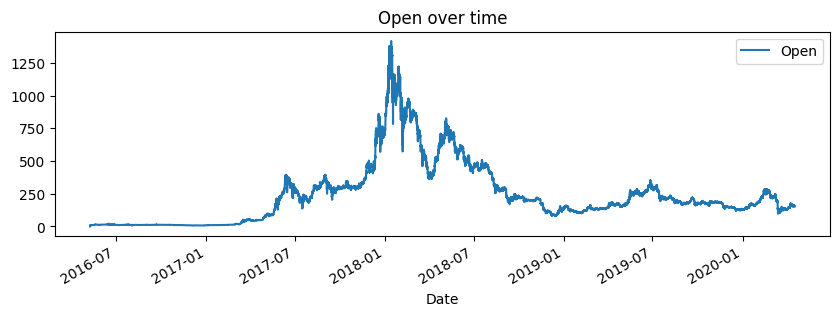

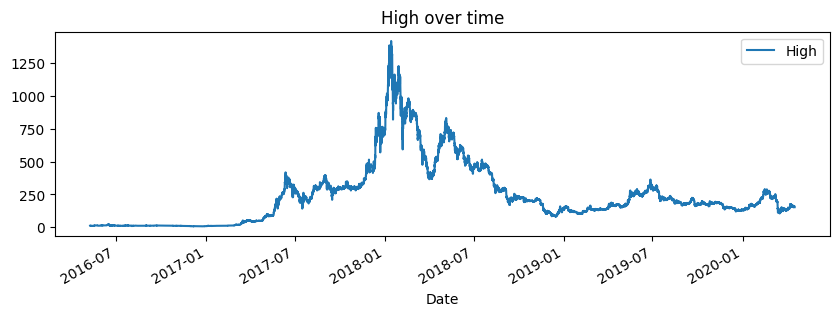

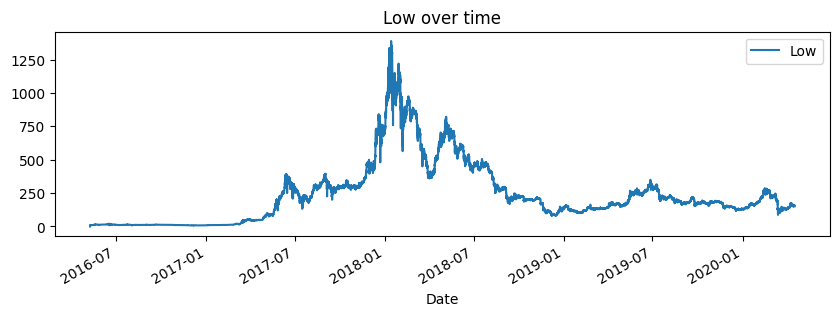

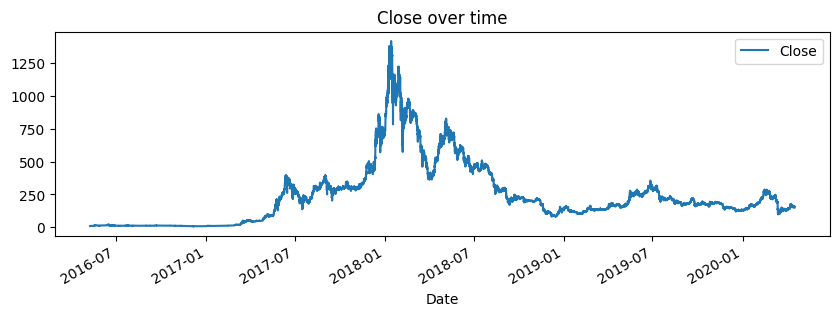

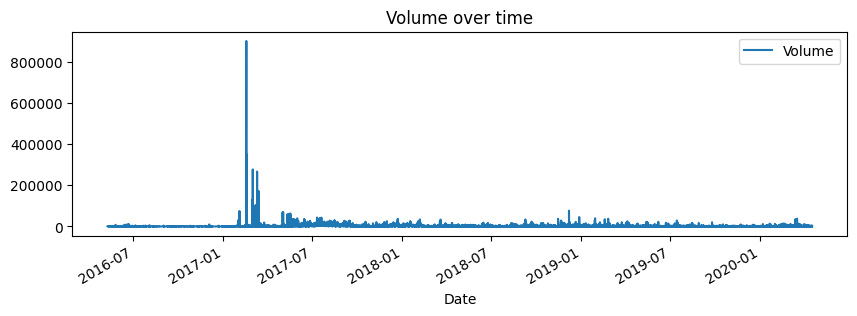

In [26]:
# Visualize each feature
print("\nVisualizing each feature:")
for column in data.columns:
    plt.figure(figsize=(10, 3))
    data[column].plot(legend=column)
    plt.title(f"{column} over time")
    plt.show()

In [27]:
# Create datetime features
def create_datetime_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [28]:
df = create_datetime_features(data)

print("\nDataset with datetime features:")
print(df.head())


Dataset with datetime features:
                      Open   High   Low  Close      Volume  hour  day  month  \
Date                                                                           
2016-05-09 13:00:00   0.00  12.00  0.00   9.55  432.562115    13    9      5   
2016-05-09 14:00:00   9.55  10.00  9.55  10.00  235.774075    14    9      5   
2016-05-09 15:00:00  10.00  10.00  9.99   9.99   10.973567    15    9      5   
2016-05-09 16:00:00   9.99   9.99  9.79   9.83   62.379450    16    9      5   
2016-05-09 17:00:00   9.83   9.83  9.48   9.49  329.553213    17    9      5   

                     year  dayofweek  dayofyear  weekofyear  
Date                                                         
2016-05-09 13:00:00  2016          0        130          19  
2016-05-09 14:00:00  2016          0        130          19  
2016-05-09 15:00:00  2016          0        130          19  
2016-05-09 16:00:00  2016          0        130          19  
2016-05-09 17:00:00  2016         

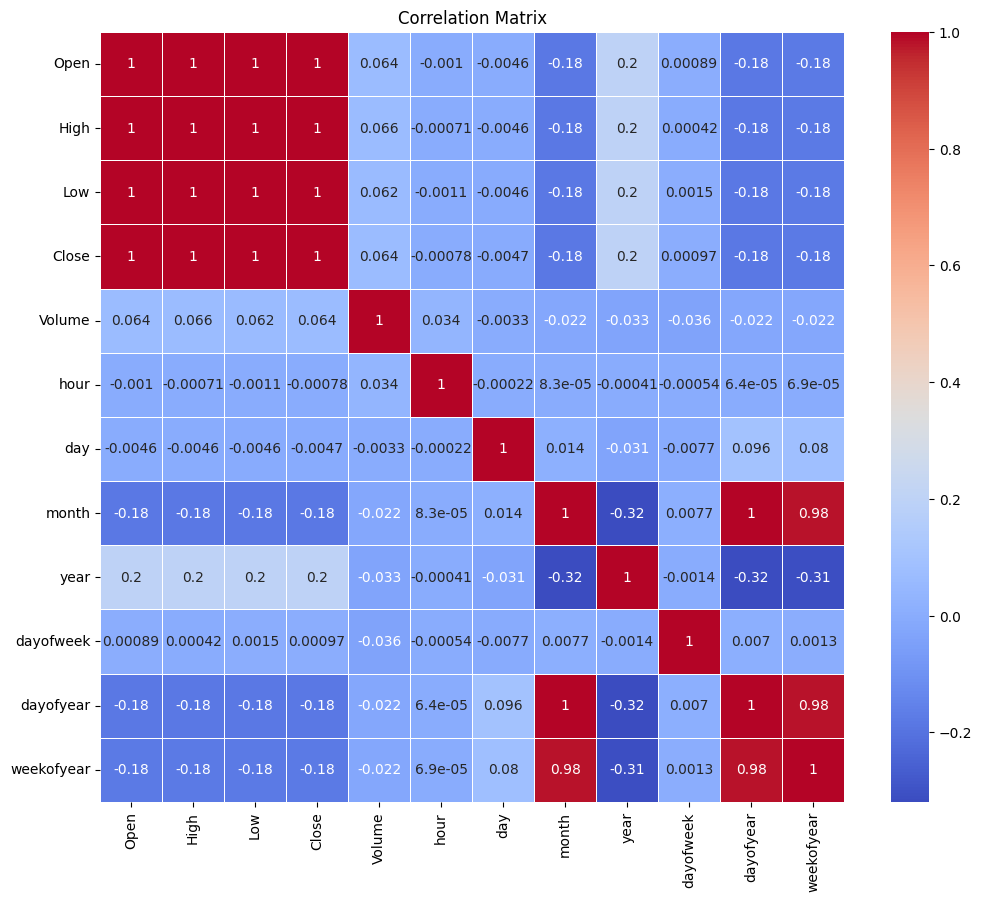

In [29]:
# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [30]:
# Prepare data for LSTM model
close_prices = df['Close']
window_size = 240  # 10 days of hourly data

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i+seq_length]
        target = data.iloc[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets).reshape(-1, 1)

In [31]:
X, y = create_sequences(close_prices, window_size)

In [32]:
# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, 1)).reshape(X.shape)
y_scaled = scaler.transform(y)

In [33]:
# Reshape input for LSTM [samples, time steps, features]
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

In [34]:
# Split the data into training and testing sets
split = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train, y_test = y_scaled[:split], y_scaled[split:]

print("\nShape of training data:", X_train.shape, y_train.shape)
print("Shape of testing data:", X_test.shape, y_test.shape)


Shape of training data: (27405, 240, 1) (27405, 1)
Shape of testing data: (6852, 240, 1) (6852, 1)


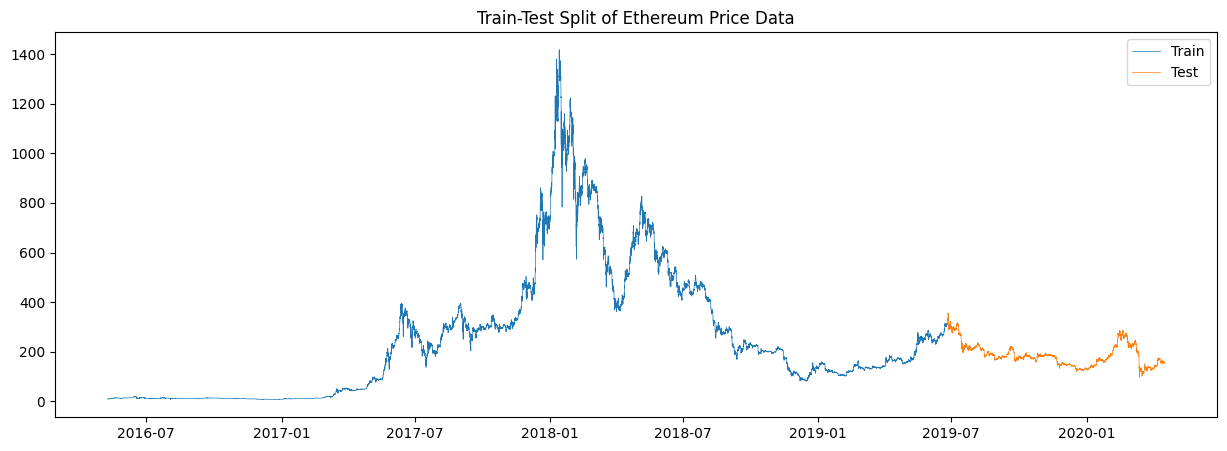

In [36]:
# Visualize train-test split
plt.figure(figsize=(15, 5))
plt.plot(df['Close'][:split], label='Train', linewidth=0.5)
plt.plot(df['Close'][split:], label='Test', linewidth=0.5)
plt.title('Train-Test Split of Ethereum Price Data')
plt.legend()
plt.show()

In [52]:
# Build and train the LSTM model
model = Sequential()
model.add(LSTM(100,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse')
print("\nModel Summary:")
model.summary()


Model Summary:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=100,
    verbose=1
)

Epoch 1/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.9899e-04
Epoch 2/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.9225e-04
Epoch 3/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.6129e-04
Epoch 4/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.7297e-04
Epoch 5/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.4388e-04


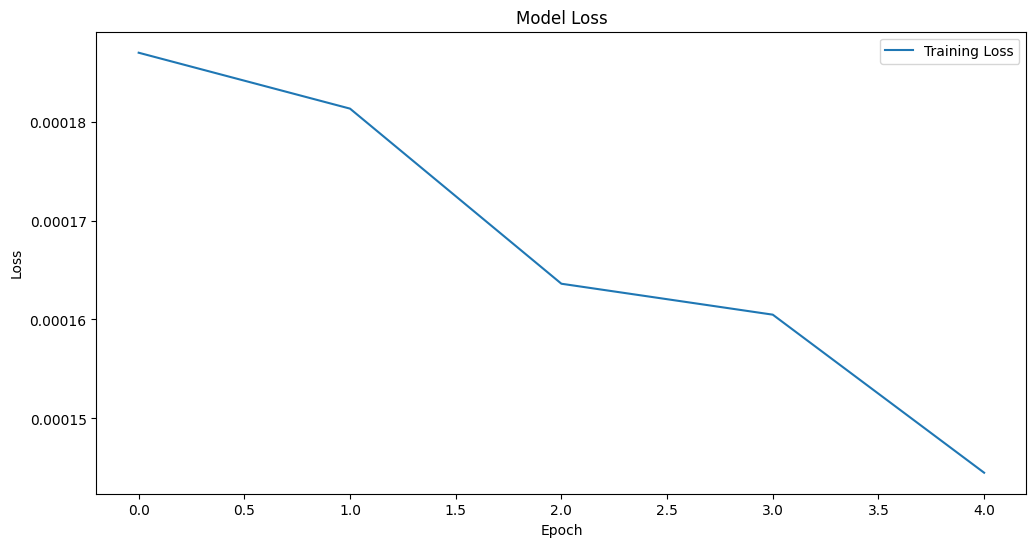

In [61]:
# Plot the learning curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [62]:
# Make predictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_inv = scaler.inverse_transform(y_test)

215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [63]:
# Calculate R-squared score
r2 = r2_score(y_test_inv, y_pred)
print(f"\nR-squared score: {r2:.4f}")


R-squared score: 0.9918


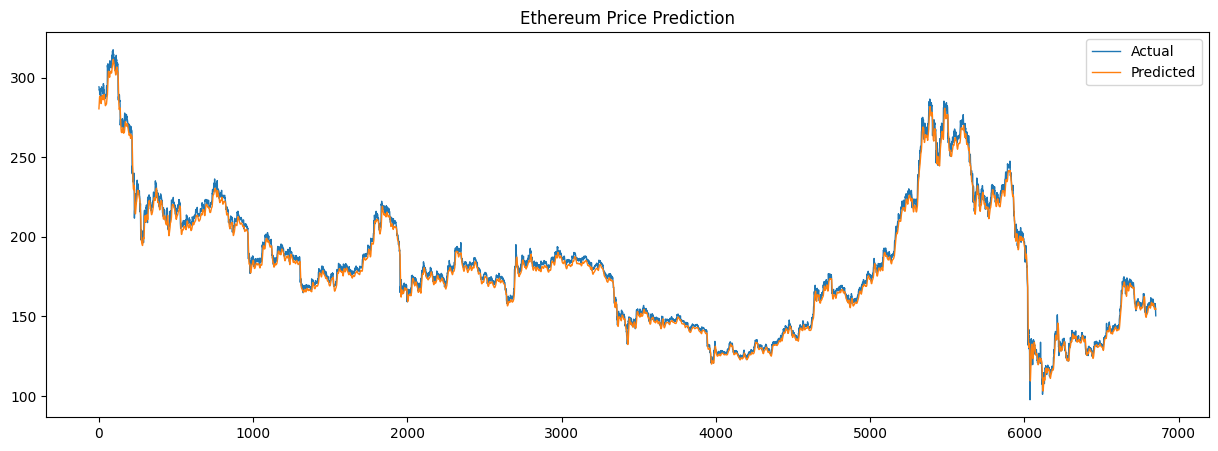

In [64]:
# Visualize predictions
plt.figure(figsize=(15, 5))
plt.plot(y_test_inv, label='Actual', linewidth=1)
plt.plot(y_pred, label='Predicted', linewidth=1)
plt.title('Ethereum Price Prediction')
plt.legend()
plt.show()

In [68]:
# Train on full dataset
X_full = X_scaled
y_full = y_scaled

In [70]:
model_full = Sequential()
model_full.add(LSTM(100, input_shape=(X_full.shape[1], X_full.shape[2])))
model_full.add(Dropout(0.2))
model_full.add(Dense(1, activation='linear'))

model_full.compile(optimizer='adam', loss='mse')

In [71]:
history_full = model_full.fit(
    X_full, y_full,
    epochs=5,
    batch_size=100,
    verbose=1
)

Epoch 1/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0031
Epoch 2/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 2.1812e-04
Epoch 3/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.8678e-04
Epoch 4/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.7420e-04
Epoch 5/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.7183e-04


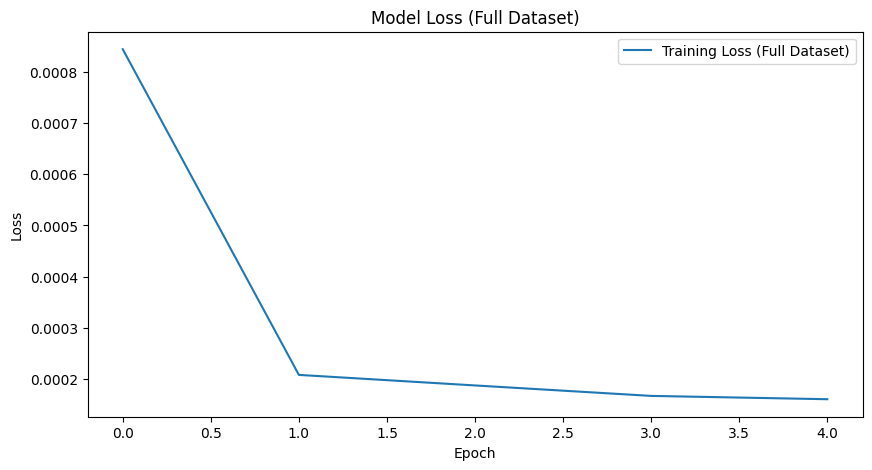

In [72]:
# Plot training history for full dataset
plt.figure(figsize=(10, 5))
plt.plot(history_full.history['loss'], label='Training Loss (Full Dataset)')
plt.title('Model Loss (Full Dataset)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [96]:
# Get the last real price
last_real_price = data['Close'].iloc[-1]

In [97]:
# Future price prediction
last_sequence = scaler.transform(data['Close'].iloc[-window_size:].values.reshape(-1, 1))
future_days = 30
future_predictions = []

for i in range(future_days * 24):
    next_pred = model_full.predict(last_sequence.reshape(1, window_size, 1))

    if i == 0:
        scaling_factor = last_real_price / scaler.inverse_transform(next_pred)[0, 0]
        next_pred = scaler.transform(np.array([[last_real_price * 1.001]]))
    else:
        noise = np.random.normal(0, 0.002, next_pred.shape)
        next_pred = next_pred + noise

    future_predictions.append(next_pred[0, 0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_pred

future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions_original = scaler.inverse_transform(future_predictions) * scaling_factor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

In [101]:
# Prepare data for visualization
historical_prices = data['Close'].values
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(hours=1), periods=len(future_predictions), freq='H')

# Create the Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True)

# Add historical data
fig.add_trace(
    go.Scatter(x=data.index, y=historical_prices, name='Historical Data', line=dict(color='blue'))
)

# Add predicted data
fig.add_trace(
    go.Scatter(x=future_dates, y=future_predictions_original.flatten(), name='Future Prediction', line=dict(color='red'))
)

# Update layout
fig.update_layout(
    title='Ethereum Price Prediction including Future Forecast',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    legend_title='Data',
    hovermode="x unified"
)

# Show the plot
fig.show()

In [75]:
from keras.models import save_model
import h5py

# Save the full dataset model
save_model(model_full, '/content/drive/MyDrive/ML/ethereum-historical-dataset/ethereum_price_model_full.h5')

# Save the scaler
with h5py.File('/content/drive/MyDrive/ML/ethereum-historical-dataset/scaler_full.h5', 'w') as hf:
    hf.create_dataset('min', data=scaler.min_)
    hf.create_dataset('scale', data=scaler.scale_)

print("Full dataset model and scaler saved.")

Full dataset model and scaler saved.
